# FeS Example Workflow 

This notebook contains a modified version of the first task of the XAS processing workflow.  

The break up of the task consist of the following steps 

| Task                            | Input                                         | Output
| -------------                   |-------------                                  | -----  
| Create Athena project      |                                               | 
| 1. Import data                |Files: 4000 Data \[.dat\] files                      | 
| 2. Normalisation              |No need as all data has been normalised in DAWN |
| 3. Save Athena Project        |                                               |Files: 4000 Athena \[.prj\] files

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/

## Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch. We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


## Libraries
The next cell shows the libraries needed for performning task 1

In [1]:


# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt

#library for writing to log
import logging

## Custom Functions
The following cell contains the defined functions (methods) for processing XAS files.
- **set_logger** intialises the logging. 
- **get_files_list** returns a list of files in the directory matching the given file pattern.
- **rename_cols** renames the energy and mu columns (col1 and col2 in the dat files).
- **plot_normalised** shows the plot of normalised data

In [33]:
# initialise log file
def set_logger(log_file):
    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename=log_file, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    # prevent matplotlib font manager from writing to log
    logging.getLogger('matplotlib.font_manager').disabled = True
    logger.setLevel(logging.DEBUG)

# reading all files with the same extension from a dir
# pattern provides the 
def get_files_list(source_dir, f_pattern):
    i_counter = 0
    files_list = []
    for filepath in sorted(source_dir.glob(f_pattern)):
        i_counter += 1
        files_list.append(filepath)
    return files_list

# Rename columns 
def rename_cols(xafs_group):
    # energy
    engy = xafs_group.col1
    # mu
    mu_e = xafs_group.col2
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu and energy to the dictionary
    xafs_dict['energy'] = engy
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group


# show plot pre-edge and post-edge fitting
def plot_mu(xafs_group):
        plt.plot(xafs_group.energy, xafs_group.mu, label=xafs_group.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("$\mu$" + xafs_group.filename)
        plt.legend() # show legend
        plt.show()
        
# show plot pre-edge and post-edge fitting
def plot_edge_fit(xafs_group):
        plt.plot(xafs_group.energy, xafs_group.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        plt.plot(xafs_group.energy, xafs_group.post_edge, 'r', label='post-edge')# plot post-edge in red
        plt.plot(xafs_group.energy, xafs_group.mu, 'b', label=xafs_group.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend
        plt.show()
        
# show plot of normalised data
def plot_normalised(xafs_group):
        #plt.plot(xafs_group.energy, xafs_group.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        #plt.plot(xafs_group.energy, xafs_group.post_edge, 'r', label='post-edge')# plot post-edge in red
        #plt.plot(xafs_group.energy, xafs_group.mu, 'b', label=xafs_group.filename) # plot mu in blue
        plt.plot(xafs_group.energy, xafs_group.flat, label=xafs_group.filename)
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend
        plt.show()

## Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

In [34]:
# variables that can be changed to process different datasets
data_path = "./"

file_pattern = "*.xmu"
f_prefix = "FeS2"
column_labels = "energy mu i0"

top_count = 40
show_graph = True # False to prevent showing graphs

## Main function
The code in the cell below performs the bulk of the processing for task 1. It calls the functions defined above and uses the input parameters.

[root] INFO : Started processing
[root] INFO : Processing: fes2_rt01_mar02.xmu
[root] INFO : Path: fes2_rt01_mar02.xmu
[root] INFO : project name: FeS2000000
[root] INFO : project path: FeS2\FeS2000000.prj


FeS2\process.log


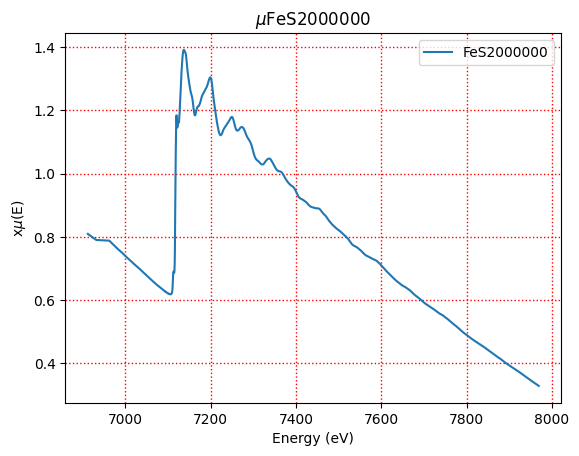

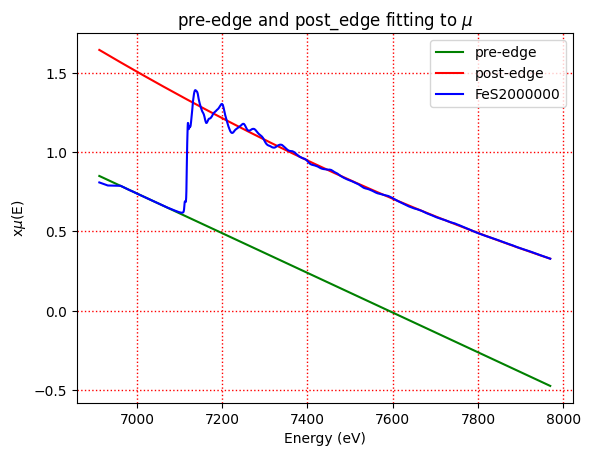

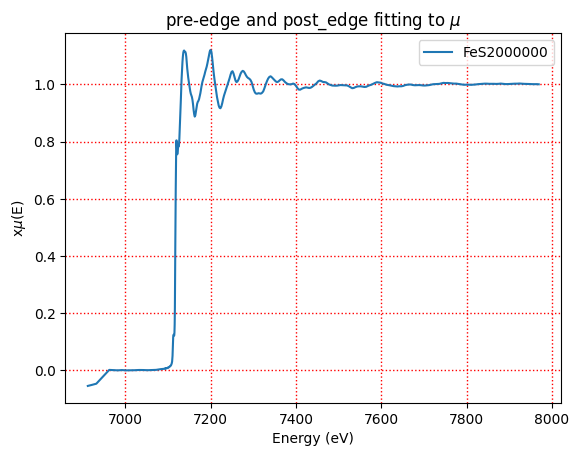

[root] INFO : Finished processing


In [35]:
# create the path for storing results
base_path = Path("./" , f_prefix)
Path(base_path).mkdir(parents=True, exist_ok=True)

log_file = Path("./",base_path,"process.log")
print(log_file)
# set path for log
set_logger(log_file)

source_path = Path(data_path)
files_list = get_files_list(source_path, file_pattern)
xas_data = {}
logging.info("Started processing")

# counter for break
i_count = 0
for a_file in files_list:
    file_name = a_file.name
    
    logging.info ("Processing: " + file_name)
    logging.info ("Path: "+ str(a_file))
    f_suffix = str(i_count).zfill(6) 
    p_name = f_prefix+f_suffix
    logging.info ("project name: "+ p_name)
    p_path = Path(base_path , p_name + ".prj")
    logging.info ("project path: "+ str(p_path))
    xas_data = read_ascii(a_file, labels=column_labels)
    # using vars(fe_xas) we see that the object has the following properties: 
    # path, filename, header, data, attrs, energy, xmu, i0
    # print(vars(xas_data))

    # rename columns and group
    #xas_data = rename_cols(xas_data)
    # the group is the same as the file name
    xas_data.filename = p_name
    
    # calculate pre-edge and post edge and add them to group
    # using defaults
    pre_edge(energy=xas_data.energy, mu=xas_data.mu , group=xas_data, pre1=-150, pre2=-60)
    
    # Show graph if needed
    if show_graph:
        plot_mu(xas_data)
        plot_edge_fit(xas_data)
        plot_normalised(xas_data)
    
    xas_project = create_athena(p_path)
    xas_project.add_group(xas_data)
    xas_project.save()
    
    i_count +=1
    if i_count == top_count:
        break
       
logging.info("Finished processing")

In [9]:
show_graph

True